In [1]:
from modules.utils_data import load_data
from modules.plotting import plot_scatter_and_line
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [5]:
%%capture
# The previous line silences the output because I don't like it

# Load the data
df_combined = load_data()

In [10]:
# Split the train/test data
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')

LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


In [11]:
# Try different dataset sizes
sizes = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 1]
out_dir = 'LogP_different_sizes/'
os.makedirs(out_dir, exist_ok=True)

stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna()

for seed in range(3):
    stl_data_shuffled = stl_data.sample(frac=1, random_state=seed)  # Shuffle data with different random seeds
    other_properties = train.drop(columns="LogP")
    for s in sizes:
        os.makedirs(out_dir + f'seed_{seed}/{s}_STL', exist_ok=True)
        stl_less_data = stl_data_shuffled[:int(len(stl_data_shuffled)*s)]
        print("frac", s, ":", len(stl_less_data))   
        stl_less_data.to_csv(out_dir + f'seed_{seed}/{s}_STL/train.csv', index=False)
        stl_test.to_csv(out_dir + f'seed_{seed}/{s}_STL/test.csv', index=False)
        os.makedirs(out_dir + f'seed_{seed}/{s}_MTL', exist_ok=True)
        mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
        mtl_less_data.to_csv(out_dir + f'seed_{seed}/{s}_MTL/train.csv', index=False)
        test.to_csv(out_dir + f'seed_{seed}/{s}_MTL/test.csv', index=False)
        properties = mtl_less_data.drop(columns='SMILES').columns.to_list()
        # train STL
        os.system(f'''chemprop train \
        --data-path {out_dir}seed_{seed}/{s}_STL/train.csv \
        --task-type regression \
        --output-dir {out_dir}seed_{seed}/{s}_STL/model/ \
        --num-workers 15 ''')

        # Predict
        os.system(f'''chemprop predict \
        --test-path {out_dir}seed_{seed}/{s}_STL/test.csv \
        --model-path {out_dir}seed_{seed}/{s}_STL/model/model_0/best.pt \
        --preds-path {out_dir}seed_{seed}/{s}_STL/preds.csv \
        --num-workers 15''')

        # train MTL
        os.system(f'''chemprop train \
        --data-path {out_dir}seed_{seed}/{s}_MTL/train.csv \
        --task-type regression \
        --target-columns {" ".join(properties)} \
        --task-weights {" ".join([str(1) if p != "LogP" else str(10) for p in properties])} \
        --output-dir {out_dir}seed_{seed}/{s}_MTL/model/ \
        --num-workers 15 ''')

        # Predict
        os.system(f'''chemprop predict \
        --test-path {out_dir}seed_{seed}/{s}_MTL/test.csv \
        --model-path {out_dir}seed_{seed}/{s}_MTL/model/model_0/best.pt \
        --preds-path {out_dir}seed_{seed}/{s}_MTL/preds.csv \
        --num-workers 15''')

frac 0.01 : 97
Wrote config file to LogP_different_sizes/seed_0/0.01_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, u

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s, v_num=1, train_loss=0.505]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s, v_num=1, train_loss=0.406, val_loss=2.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, v_num=1, train_loss=0.432, val_loss=2.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  4.71it/s, v_num=1, train_loss=0.401, val_loss=2.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s, v_num=1, train_loss=0.444, val_loss=2.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s, v_num=1, train_loss=0.614, val_loss=2.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, v_num=1, train_loss=0.176, val_loss=2.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.01_STL/model/model_0/checkpoints/best-epoch=48-val_loss=1.30.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.01_STL/model/model_0/checkpoints/best-epoch=48-val_loss=1.30.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.61it/s]
Entire Test Set results: {'entire_test/mse': 2.4651597001664602}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 86.92it/s]
Wrote config file to LogP_different_sizes/seed_0/0.01_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 102.31it/s, v_num=1, train_loss=0.0917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 90.42it/s, v_num=1, train_loss=0.674, val_loss=0.518] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 88.71it/s, v_num=1, train_loss=0.314, val_loss=0.358]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 88.80it/s, v_num=1, train_loss=0.576, val_loss=0.511]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 84.47it/s, v_num=1, train_loss=0.203, val_loss=0.464]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 87.11it/s, v_num=1, train_loss=0.184, val_loss=0.301] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 85.92it/s, v_num=1, train_loss=0.339, val_loss=0.287] 
Validation: |        

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.01_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.01_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.18.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 231.81it/s]
Entire Test Set results: {'entire_test/mse': 671.8093578124553}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 123.09it/s]
frac 0.05 : 485
Wrote config file to LogP_different_sizes/seed_0/0.05_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 42.42it/s, v_num=1, train_loss=0.991]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 15.84it/s, v_num=1, train_loss=1.690, val_loss=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 14.97it/s, v_num=1, train_loss=0.119, val_loss=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 14.25it/s, v_num=1, train_loss=0.346, val_loss=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 15.96it/s, v_num=1, train_loss=0.450, val_loss=0.992]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 14.30it/s, v_num=1, train_loss=0.770, val_loss=0.851]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 15.87it/s, v_num=1, train_loss=0.408, val_loss=0.748]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.05_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.32.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.05_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.32.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.24it/s]
Entire Test Set results: {'entire_test/mse': 0.9992496401859222}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 105.14it/s]
Wrote config file to LogP_different_sizes/seed_0/0.05_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 106.76it/s, v_num=1, train_loss=0.181]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 89.74it/s, v_num=1, train_loss=0.683, val_loss=0.446]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 87.28it/s, v_num=1, train_loss=0.370, val_loss=0.358]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 90.68it/s, v_num=1, train_loss=0.574, val_loss=0.395]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 89.45it/s, v_num=1, train_loss=0.218, val_loss=0.336] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 86.10it/s, v_num=1, train_loss=0.213, val_loss=0.291]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 85.11it/s, v_num=1, train_loss=0.388, val_loss=0.287] 
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.05_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.05_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 230.14it/s]
Entire Test Set results: {'entire_test/mse': 662.6303490870266}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 128.01it/s]
frac 0.1 : 971
Wrote config file to LogP_different_sizes/seed_0/0.1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 58.61it/s, v_num=1, train_loss=0.233]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 25.55it/s, v_num=1, train_loss=1.420, val_loss=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 25.86it/s, v_num=1, train_loss=0.240, val_loss=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 22.91it/s, v_num=1, train_loss=0.112, val_loss=0.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 24.03it/s, v_num=1, train_loss=0.113, val_loss=0.582]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 24.34it/s, v_num=1, train_loss=0.431, val_loss=0.545]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 24.99it/s, v_num=1, train_loss=0.139, val_loss=0.312]
Validation: |          | 0/? [00:00<?, ?

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.1_STL/model/model_0/checkpoints/best-epoch=47-val_loss=0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.1_STL/model/model_0/checkpoints/best-epoch=47-val_loss=0.16.ckpt


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 313.72it/s]
Entire Test Set results: {'entire_test/mse': 0.5074139325311157}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 93.88it/s]
Wrote config file to LogP_different_sizes/seed_0/0.1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 101.04it/s, v_num=1, train_loss=0.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.02it/s, v_num=1, train_loss=0.710, val_loss=0.441]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 83.74it/s, v_num=1, train_loss=0.311, val_loss=0.331]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.46it/s, v_num=1, train_loss=0.553, val_loss=0.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 81.52it/s, v_num=1, train_loss=0.165, val_loss=0.378] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 80.30it/s, v_num=1, train_loss=0.233, val_loss=0.242]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 80.62it/s, v_num=1, train_loss=0.272, val_loss=0.256] 
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.1_MTL/model/model_0/checkpoints/best-epoch=49-val_loss=0.18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.1_MTL/model/model_0/checkpoints/best-epoch=49-val_loss=0.18.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 251.90it/s]
Entire Test Set results: {'entire_test/mse': 683.1407415083531}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 116.94it/s]
frac 0.25 : 2428
Wrote config file to LogP_different_sizes/seed_0/0.25_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 31/31 [00:00<00:00, 76.60it/s, v_num=1, train_loss=0.345]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 31/31 [00:00<00:00, 44.93it/s, v_num=1, train_loss=0.136, val_loss=0.776]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 31/31 [00:00<00:00, 43.41it/s, v_num=1, train_loss=0.150, val_loss=0.475]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 31/31 [00:00<00:00, 40.97it/s, v_num=1, train_loss=0.340, val_loss=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 42.73it/s, v_num=1, train_loss=0.206, val_loss=0.243]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 31/31 [00:00<00:00, 43.77it/s, v_num=1, train_loss=0.0888, val_loss=0.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 31/31 [00:00<00:00, 42.48it/s, v_num=1, train_loss=0.492, val_loss=0.184] 
Validation: |          | 0/? [00:00<?,

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.25_STL/model/model_0/checkpoints/best-epoch=45-val_loss=0.07.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.25_STL/model/model_0/checkpoints/best-epoch=45-val_loss=0.07.ckpt


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.92it/s]
Entire Test Set results: {'entire_test/mse': 0.44154625714774315}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 95.39it/s]
Wrote config file to LogP_different_sizes/seed_0/0.25_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 106.20it/s, v_num=1, train_loss=0.298]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 90.24it/s, v_num=1, train_loss=0.773, val_loss=0.524]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 86.05it/s, v_num=1, train_loss=0.280, val_loss=0.334]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.43it/s, v_num=1, train_loss=0.477, val_loss=0.545] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.01it/s, v_num=1, train_loss=0.222, val_loss=0.378] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 86.86it/s, v_num=1, train_loss=0.227, val_loss=0.281]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 82.95it/s, v_num=1, train_loss=0.202, val_loss=0.253] 
Validation: |         

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.25_MTL/model/model_0/checkpoints/best-epoch=35-val_loss=0.17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.25_MTL/model/model_0/checkpoints/best-epoch=35-val_loss=0.17.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 252.37it/s]
Entire Test Set results: {'entire_test/mse': 649.4002353737518}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 121.11it/s]
frac 0.5 : 4856
Wrote config file to LogP_different_sizes/seed_0/0.5_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 61/61 [00:00<00:00, 86.39it/s, v_num=1, train_loss=0.581]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 58.93it/s, v_num=1, train_loss=0.147, val_loss=0.739]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 57.61it/s, v_num=1, train_loss=0.285, val_loss=0.673] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 54.91it/s, v_num=1, train_loss=0.149, val_loss=0.216]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 54.16it/s, v_num=1, train_loss=0.0701, val_loss=0.343]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 57.50it/s, v_num=1, train_loss=0.0771, val_loss=0.192]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 61/61 [00:01<00:00, 54.84it/s, v_num=1, train_loss=0.152, val_loss=0.201] 
Validation: |          | 0/? [00:00<

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.5_STL/model/model_0/checkpoints/best-epoch=46-val_loss=0.10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.5_STL/model/model_0/checkpoints/best-epoch=46-val_loss=0.10.ckpt


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 257.38it/s]
Entire Test Set results: {'entire_test/mse': 0.3746198387398706}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 80.42it/s]
Wrote config file to LogP_different_sizes/seed_0/0.5_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 107.85it/s, v_num=1, train_loss=0.218]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 89.37it/s, v_num=1, train_loss=0.673, val_loss=0.339]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 87.65it/s, v_num=1, train_loss=0.345, val_loss=0.315]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 87.57it/s, v_num=1, train_loss=0.473, val_loss=0.438] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 86.55it/s, v_num=1, train_loss=0.218, val_loss=0.289]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 86.71it/s, v_num=1, train_loss=0.257, val_loss=0.278] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 80.15it/s, v_num=1, train_loss=0.225, val_loss=0.281]
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.5_MTL/model/model_0/checkpoints/best-epoch=27-val_loss=0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.5_MTL/model/model_0/checkpoints/best-epoch=27-val_loss=0.16.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 260.00it/s]
Entire Test Set results: {'entire_test/mse': 559.8584478682737}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 130.15it/s]
frac 0.75 : 7284
Wrote config file to LogP_different_sizes/seed_0/0.75_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 92/92 [00:00<00:00, 94.13it/s, v_num=1, train_loss=0.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 92/92 [00:01<00:00, 68.17it/s, v_num=1, train_loss=0.0328, val_loss=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 92/92 [00:01<00:00, 72.02it/s, v_num=1, train_loss=0.567, val_loss=0.339] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 92/92 [00:01<00:00, 72.08it/s, v_num=1, train_loss=0.202, val_loss=0.283] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 92/92 [00:01<00:00, 70.44it/s, v_num=1, train_loss=0.224, val_loss=0.212] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 92/92 [00:01<00:00, 70.81it/s, v_num=1, train_loss=0.0505, val_loss=0.243]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 92/92 [00:01<00:00, 71.59it/s, v_num=1, train_loss=0.297, val_loss=0.146] 
Validation: |          | 0/? [00:0

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.75_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.09.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.75_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.09.ckpt


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 238.24it/s]
Entire Test Set results: {'entire_test/mse': 0.313801534201706}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 101.39it/s]
Wrote config file to LogP_different_sizes/seed_0/0.75_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 98.57it/s, v_num=1, train_loss=0.158]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 83.76it/s, v_num=1, train_loss=0.902, val_loss=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 86.48it/s, v_num=1, train_loss=0.370, val_loss=0.322]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.57it/s, v_num=1, train_loss=0.439, val_loss=0.395]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.47it/s, v_num=1, train_loss=0.237, val_loss=0.238] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 87.12it/s, v_num=1, train_loss=0.210, val_loss=0.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 86.32it/s, v_num=1, train_loss=0.169, val_loss=0.248] 
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.75_MTL/model/model_0/checkpoints/best-epoch=35-val_loss=0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/0.75_MTL/model/model_0/checkpoints/best-epoch=35-val_loss=0.16.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 203.63it/s]
Entire Test Set results: {'entire_test/mse': 458.0603303905362}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 120.00it/s]
frac 1 : 9713
Wrote config file to LogP_different_sizes/seed_0/1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 94.31it/s, v_num=1, train_loss=0.323]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 122/122 [00:01<00:00, 67.27it/s, v_num=1, train_loss=0.211, val_loss=0.326]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 122/122 [00:01<00:00, 69.86it/s, v_num=1, train_loss=0.364, val_loss=0.479]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 122/122 [00:01<00:00, 74.16it/s, v_num=1, train_loss=0.0887, val_loss=0.291]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 122/122 [00:01<00:00, 71.81it/s, v_num=1, train_loss=0.121, val_loss=0.171] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 122/122 [00:01<00:00, 71.63it/s, v_num=1, train_loss=0.101, val_loss=0.128] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 122/122 [00:01<00:00, 71.01it/s, v_num=1, train_loss=0.161, val_loss=0.123] 
Validation: |         

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/1_STL/model/model_0/checkpoints/best-epoch=39-val_loss=0.07.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/1_STL/model/model_0/checkpoints/best-epoch=39-val_loss=0.07.ckpt


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 193.82it/s]
Entire Test Set results: {'entire_test/mse': 0.22353779772880744}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 87.82it/s]
Wrote config file to LogP_different_sizes/seed_0/1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 100.85it/s, v_num=1, train_loss=0.142]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 83.39it/s, v_num=1, train_loss=1.060, val_loss=0.428]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 82.50it/s, v_num=1, train_loss=0.248, val_loss=0.319]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 82.69it/s, v_num=1, train_loss=0.451, val_loss=0.427] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 82.49it/s, v_num=1, train_loss=0.234, val_loss=0.251] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 83.09it/s, v_num=1, train_loss=0.188, val_loss=0.266] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 83.53it/s, v_num=1, train_loss=0.158, val_loss=0.220] 
Validation: |        

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/1_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_0/1_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.14.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 182.59it/s]
Entire Test Set results: {'entire_test/mse': 444.8581691074828}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 122.88it/s]
frac 0.01 : 97
Wrote config file to LogP_different_sizes/seed_1/0.01_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, u

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, v_num=1, train_loss=0.606]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, v_num=1, train_loss=0.819, val_loss=0.527]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s, v_num=1, train_loss=1.380, val_loss=0.536]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, v_num=1, train_loss=0.217, val_loss=0.538]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, v_num=1, train_loss=0.249, val_loss=0.526]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  4.41it/s, v_num=1, train_loss=0.309, val_loss=0.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s, v_num=1, train_loss=0.398, val_loss=0.517]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.01_STL/model/model_0/checkpoints/best-epoch=43-val_loss=0.31.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.01_STL/model/model_0/checkpoints/best-epoch=43-val_loss=0.31.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.42it/s]
Entire Test Set results: {'entire_test/mse': 1.6821242968121397}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 99.19it/s]
Wrote config file to LogP_different_sizes/seed_1/0.01_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 98.26it/s, v_num=1, train_loss=0.101]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 80.90it/s, v_num=1, train_loss=0.776, val_loss=0.464]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.06it/s, v_num=1, train_loss=0.239, val_loss=0.351]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.50it/s, v_num=1, train_loss=0.595, val_loss=0.443] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 80.53it/s, v_num=1, train_loss=0.184, val_loss=0.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 85.19it/s, v_num=1, train_loss=0.188, val_loss=0.286]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 83.85it/s, v_num=1, train_loss=0.275, val_loss=0.264] 
Validation: |          |

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.01_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.01_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 235.82it/s]
Entire Test Set results: {'entire_test/mse': 676.7386597431874}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 111.83it/s]
frac 0.05 : 485
Wrote config file to LogP_different_sizes/seed_1/0.05_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 40.56it/s, v_num=1, train_loss=0.674]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 13.64it/s, v_num=1, train_loss=0.555, val_loss=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, v_num=1, train_loss=0.182, val_loss=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 13.99it/s, v_num=1, train_loss=0.494, val_loss=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s, v_num=1, train_loss=0.712, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 13.98it/s, v_num=1, train_loss=0.391, val_loss=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 13.11it/s, v_num=1, train_loss=0.324, val_loss=0.874]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.05_STL/model/model_0/checkpoints/best-epoch=26-val_loss=0.28.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.05_STL/model/model_0/checkpoints/best-epoch=26-val_loss=0.28.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.79it/s]
Entire Test Set results: {'entire_test/mse': 0.47230881541084985}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 93.93it/s]
Wrote config file to LogP_different_sizes/seed_1/0.05_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 102.23it/s, v_num=1, train_loss=0.134]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 82.40it/s, v_num=1, train_loss=0.550, val_loss=0.564]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 78.96it/s, v_num=1, train_loss=0.342, val_loss=0.398]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 81.92it/s, v_num=1, train_loss=0.660, val_loss=0.470] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 81.71it/s, v_num=1, train_loss=0.168, val_loss=0.321]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 81.22it/s, v_num=1, train_loss=0.216, val_loss=0.297] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 82.28it/s, v_num=1, train_loss=0.283, val_loss=0.254] 
Validation: |         

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.05_MTL/model/model_0/checkpoints/best-epoch=9-val_loss=0.20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.05_MTL/model/model_0/checkpoints/best-epoch=9-val_loss=0.20.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 259.67it/s]
Entire Test Set results: {'entire_test/mse': 728.9020092121484}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 127.08it/s]
frac 0.1 : 971
Wrote config file to LogP_different_sizes/seed_1/0.1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 57.88it/s, v_num=1, train_loss=0.487]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 22.99it/s, v_num=1, train_loss=0.453, val_loss=0.812]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 21.14it/s, v_num=1, train_loss=0.690, val_loss=0.782]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 21.87it/s, v_num=1, train_loss=0.131, val_loss=0.564]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 21.38it/s, v_num=1, train_loss=0.181, val_loss=0.384]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 22.69it/s, v_num=1, train_loss=0.473, val_loss=0.315]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 19.73it/s, v_num=1, train_loss=0.381, val_loss=0.339]
Validation: |          | 0/? [00:00<?, ?

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.1_STL/model/model_0/checkpoints/best-epoch=46-val_loss=0.12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.1_STL/model/model_0/checkpoints/best-epoch=46-val_loss=0.12.ckpt


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 365.04it/s]
Entire Test Set results: {'entire_test/mse': 0.5206422854245871}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 100.85it/s]
Wrote config file to LogP_different_sizes/seed_1/0.1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 101.59it/s, v_num=1, train_loss=0.101]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.72it/s, v_num=1, train_loss=0.545, val_loss=0.413]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 85.66it/s, v_num=1, train_loss=0.249, val_loss=0.347]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 88.29it/s, v_num=1, train_loss=0.576, val_loss=0.499]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 87.35it/s, v_num=1, train_loss=0.181, val_loss=0.378]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 85.30it/s, v_num=1, train_loss=0.187, val_loss=0.254]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 86.53it/s, v_num=1, train_loss=0.278, val_loss=0.252] 
Validation: |          |

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.1_MTL/model/model_0/checkpoints/best-epoch=28-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.1_MTL/model/model_0/checkpoints/best-epoch=28-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 231.89it/s]
Entire Test Set results: {'entire_test/mse': 693.8527267840492}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 115.86it/s]
frac 0.25 : 2428
Wrote config file to LogP_different_sizes/seed_1/0.25_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 31/31 [00:00<00:00, 77.88it/s, v_num=1, train_loss=0.184]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 31/31 [00:00<00:00, 40.51it/s, v_num=1, train_loss=0.391, val_loss=0.915]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 31/31 [00:00<00:00, 40.11it/s, v_num=1, train_loss=0.164, val_loss=0.609]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 31/31 [00:00<00:00, 38.32it/s, v_num=1, train_loss=0.174, val_loss=0.658]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 40.26it/s, v_num=1, train_loss=0.231, val_loss=0.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 31/31 [00:00<00:00, 38.37it/s, v_num=1, train_loss=0.149, val_loss=0.198] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 31/31 [00:00<00:00, 38.55it/s, v_num=1, train_loss=0.174, val_loss=0.416] 
Validation: |          | 0/? [00:00<?,

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.25_STL/model/model_0/checkpoints/best-epoch=44-val_loss=0.13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.25_STL/model/model_0/checkpoints/best-epoch=44-val_loss=0.13.ckpt


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 165.79it/s]
Entire Test Set results: {'entire_test/mse': 0.3114125772513908}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 97.21it/s]
Wrote config file to LogP_different_sizes/seed_1/0.25_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 105.92it/s, v_num=1, train_loss=0.0932]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 85.23it/s, v_num=1, train_loss=0.546, val_loss=0.564] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.46it/s, v_num=1, train_loss=0.264, val_loss=0.332]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 84.57it/s, v_num=1, train_loss=0.604, val_loss=0.410] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.17it/s, v_num=1, train_loss=0.244, val_loss=0.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 84.38it/s, v_num=1, train_loss=0.157, val_loss=0.268] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 85.15it/s, v_num=1, train_loss=0.285, val_loss=0.241] 
Validation: |       

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.25_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.25_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.17.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 237.41it/s]
Entire Test Set results: {'entire_test/mse': 605.8617452443643}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 117.30it/s]
frac 0.5 : 4856
Wrote config file to LogP_different_sizes/seed_1/0.5_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 61/61 [00:00<00:00, 80.54it/s, v_num=1, train_loss=0.218]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 57.99it/s, v_num=1, train_loss=0.247, val_loss=0.545]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 56.47it/s, v_num=1, train_loss=0.161, val_loss=0.256]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 55.95it/s, v_num=1, train_loss=0.212, val_loss=0.232] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 59.89it/s, v_num=1, train_loss=0.102, val_loss=0.305] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 58.90it/s, v_num=1, train_loss=0.0759, val_loss=0.296]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 61/61 [00:01<00:00, 57.38it/s, v_num=1, train_loss=0.128, val_loss=0.200] 
Validation: |          | 0/? [00:00<

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.5_STL/model/model_0/checkpoints/best-epoch=41-val_loss=0.09.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.5_STL/model/model_0/checkpoints/best-epoch=41-val_loss=0.09.ckpt


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 173.25it/s]
Entire Test Set results: {'entire_test/mse': 0.3333057224660162}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 99.56it/s]
Wrote config file to LogP_different_sizes/seed_1/0.5_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 101.99it/s, v_num=1, train_loss=0.232]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.61it/s, v_num=1, train_loss=0.591, val_loss=0.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.51it/s, v_num=1, train_loss=0.339, val_loss=0.306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 87.92it/s, v_num=1, train_loss=0.537, val_loss=0.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 86.75it/s, v_num=1, train_loss=0.189, val_loss=0.259]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 87.68it/s, v_num=1, train_loss=0.197, val_loss=0.309]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 84.71it/s, v_num=1, train_loss=0.199, val_loss=0.241] 
Validation: |          |

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.5_MTL/model/model_0/checkpoints/best-epoch=32-val_loss=0.17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.5_MTL/model/model_0/checkpoints/best-epoch=32-val_loss=0.17.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 230.50it/s]
Entire Test Set results: {'entire_test/mse': 527.3398334350829}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 118.19it/s]
frac 0.75 : 7284
Wrote config file to LogP_different_sizes/seed_1/0.75_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 92/92 [00:00<00:00, 95.36it/s, v_num=1, train_loss=0.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 92/92 [00:01<00:00, 71.91it/s, v_num=1, train_loss=0.992, val_loss=0.403]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 92/92 [00:01<00:00, 70.52it/s, v_num=1, train_loss=0.0547, val_loss=0.302]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 92/92 [00:01<00:00, 70.50it/s, v_num=1, train_loss=0.700, val_loss=0.261] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 92/92 [00:01<00:00, 70.60it/s, v_num=1, train_loss=0.553, val_loss=0.242] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 92/92 [00:01<00:00, 69.25it/s, v_num=1, train_loss=0.973, val_loss=0.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 92/92 [00:01<00:00, 64.83it/s, v_num=1, train_loss=0.628, val_loss=0.168] 
Validation: |          | 0/? [00:00

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.75_STL/model/model_0/checkpoints/best-epoch=48-val_loss=0.08.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.75_STL/model/model_0/checkpoints/best-epoch=48-val_loss=0.08.ckpt


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 190.52it/s]
Entire Test Set results: {'entire_test/mse': 0.32493931350564265}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 88.00it/s]
Wrote config file to LogP_different_sizes/seed_1/0.75_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 98.52it/s, v_num=1, train_loss=0.151]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.09it/s, v_num=1, train_loss=0.880, val_loss=0.505]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 85.13it/s, v_num=1, train_loss=0.304, val_loss=0.626]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 82.78it/s, v_num=1, train_loss=0.535, val_loss=0.555]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 83.27it/s, v_num=1, train_loss=0.245, val_loss=0.331] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 82.44it/s, v_num=1, train_loss=0.255, val_loss=0.247]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 87.46it/s, v_num=1, train_loss=0.177, val_loss=0.228] 
Validation: |          |

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.75_MTL/model/model_0/checkpoints/best-epoch=40-val_loss=0.15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/0.75_MTL/model/model_0/checkpoints/best-epoch=40-val_loss=0.15.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 194.61it/s]
Entire Test Set results: {'entire_test/mse': 552.3035556211964}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 130.69it/s]
frac 1 : 9713
Wrote config file to LogP_different_sizes/seed_1/1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 100.08it/s, v_num=1, train_loss=0.782]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 122/122 [00:01<00:00, 79.73it/s, v_num=1, train_loss=0.289, val_loss=0.387]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 122/122 [00:01<00:00, 79.22it/s, v_num=1, train_loss=0.170, val_loss=0.309]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 122/122 [00:01<00:00, 75.96it/s, v_num=1, train_loss=0.141, val_loss=0.164] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 122/122 [00:01<00:00, 75.16it/s, v_num=1, train_loss=0.154, val_loss=0.199] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 122/122 [00:01<00:00, 73.14it/s, v_num=1, train_loss=0.219, val_loss=0.192] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 122/122 [00:01<00:00, 79.23it/s, v_num=1, train_loss=0.124, val_loss=0.146] 
Validation: |        

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/1_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.07.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/1_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.07.ckpt


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 213.90it/s]
Entire Test Set results: {'entire_test/mse': 0.24142151631207726}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 98.83it/s]
Wrote config file to LogP_different_sizes/seed_1/1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 102.19it/s, v_num=1, train_loss=0.143]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 87.51it/s, v_num=1, train_loss=0.987, val_loss=0.487]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 85.57it/s, v_num=1, train_loss=0.300, val_loss=0.276]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 81.78it/s, v_num=1, train_loss=0.361, val_loss=0.542] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.52it/s, v_num=1, train_loss=0.260, val_loss=0.234] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 83.90it/s, v_num=1, train_loss=0.176, val_loss=0.258] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 83.14it/s, v_num=1, train_loss=0.173, val_loss=0.198] 
Validation: |        

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/1_MTL/model/model_0/checkpoints/best-epoch=23-val_loss=0.14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_1/1_MTL/model/model_0/checkpoints/best-epoch=23-val_loss=0.14.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 189.33it/s]
Entire Test Set results: {'entire_test/mse': 457.92906776928504}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 130.32it/s]
frac 0.01 : 97
Wrote config file to LogP_different_sizes/seed_2/0.01_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, u

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, v_num=1, train_loss=0.389]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s, v_num=1, train_loss=0.501, val_loss=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, v_num=1, train_loss=0.386, val_loss=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, v_num=1, train_loss=0.487, val_loss=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, v_num=1, train_loss=0.176, val_loss=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, v_num=1, train_loss=0.128, val_loss=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s, v_num=1, train_loss=0.431, val_loss=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.01_STL/model/model_0/checkpoints/best-epoch=33-val_loss=0.65.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.01_STL/model/model_0/checkpoints/best-epoch=33-val_loss=0.65.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.28it/s]
Entire Test Set results: {'entire_test/mse': 1.9687021205369626}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 98.45it/s]
Wrote config file to LogP_different_sizes/seed_2/0.01_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 102.74it/s, v_num=1, train_loss=0.083]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 83.37it/s, v_num=1, train_loss=0.670, val_loss=0.640]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 80.20it/s, v_num=1, train_loss=0.352, val_loss=0.547]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 81.06it/s, v_num=1, train_loss=0.608, val_loss=0.418]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 79.44it/s, v_num=1, train_loss=0.266, val_loss=0.365]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 79.83it/s, v_num=1, train_loss=0.230, val_loss=0.311]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 81.68it/s, v_num=1, train_loss=0.303, val_loss=0.260] 
Validation: |          |

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.01_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.01_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 247.69it/s]
Entire Test Set results: {'entire_test/mse': 785.6950074934834}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 111.51it/s]
frac 0.05 : 485
Wrote config file to LogP_different_sizes/seed_2/0.05_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 40.77it/s, v_num=1, train_loss=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 13.15it/s, v_num=1, train_loss=0.374, val_loss=0.697]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s, v_num=1, train_loss=0.164, val_loss=0.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 13.05it/s, v_num=1, train_loss=0.141, val_loss=0.641]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 13.51it/s, v_num=1, train_loss=0.431, val_loss=0.564]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 13.10it/s, v_num=1, train_loss=0.347, val_loss=0.525]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 12.84it/s, v_num=1, train_loss=0.475, val_loss=0.393]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.05_STL/model/model_0/checkpoints/best-epoch=31-val_loss=0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.05_STL/model/model_0/checkpoints/best-epoch=31-val_loss=0.16.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.22it/s]
Entire Test Set results: {'entire_test/mse': 0.7721927602317946}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 84.47it/s]
Wrote config file to LogP_different_sizes/seed_2/0.05_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 103.57it/s, v_num=1, train_loss=0.0998]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 85.72it/s, v_num=1, train_loss=0.582, val_loss=0.474] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.24it/s, v_num=1, train_loss=0.259, val_loss=0.357]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.51it/s, v_num=1, train_loss=0.581, val_loss=0.441] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.42it/s, v_num=1, train_loss=0.260, val_loss=0.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 85.81it/s, v_num=1, train_loss=0.186, val_loss=0.278]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 85.40it/s, v_num=1, train_loss=0.250, val_loss=0.237] 
Validation: |        

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.05_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.05_MTL/model/model_0/checkpoints/best-epoch=38-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 248.19it/s]
Entire Test Set results: {'entire_test/mse': 719.8036970835332}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 129.07it/s]
frac 0.1 : 971
Wrote config file to LogP_different_sizes/seed_2/0.1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 58.66it/s, v_num=1, train_loss=0.304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 25.20it/s, v_num=1, train_loss=0.219, val_loss=0.769]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 26.34it/s, v_num=1, train_loss=0.0905, val_loss=0.671]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 26.80it/s, v_num=1, train_loss=0.304, val_loss=0.579] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 25.61it/s, v_num=1, train_loss=0.220, val_loss=0.448]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 28.01it/s, v_num=1, train_loss=0.212, val_loss=0.673]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 27.11it/s, v_num=1, train_loss=0.228, val_loss=0.353]
Validation: |          | 0/? [00:00<?,

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.1_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.1_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.20.ckpt


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 270.32it/s]
Entire Test Set results: {'entire_test/mse': 0.5293293450836893}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 84.95it/s]
Wrote config file to LogP_different_sizes/seed_2/0.1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 103.35it/s, v_num=1, train_loss=0.0936]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.80it/s, v_num=1, train_loss=0.737, val_loss=0.425] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 83.81it/s, v_num=1, train_loss=0.286, val_loss=0.389]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 86.07it/s, v_num=1, train_loss=0.610, val_loss=0.421]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 86.28it/s, v_num=1, train_loss=0.227, val_loss=0.354]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 84.21it/s, v_num=1, train_loss=0.242, val_loss=0.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 84.74it/s, v_num=1, train_loss=0.221, val_loss=0.281]
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.1_MTL/model/model_0/checkpoints/best-epoch=31-val_loss=0.18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.1_MTL/model/model_0/checkpoints/best-epoch=31-val_loss=0.18.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 258.14it/s]
Entire Test Set results: {'entire_test/mse': 673.832446987467}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 121.39it/s]
frac 0.25 : 2428
Wrote config file to LogP_different_sizes/seed_2/0.25_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 31/31 [00:00<00:00, 74.83it/s, v_num=1, train_loss=0.225]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 31/31 [00:00<00:00, 39.38it/s, v_num=1, train_loss=0.445, val_loss=0.816]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 31/31 [00:00<00:00, 38.53it/s, v_num=1, train_loss=0.415, val_loss=0.769]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 31/31 [00:00<00:00, 37.50it/s, v_num=1, train_loss=0.331, val_loss=0.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 39.05it/s, v_num=1, train_loss=0.171, val_loss=0.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 31/31 [00:00<00:00, 38.57it/s, v_num=1, train_loss=0.135, val_loss=0.226]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 31/31 [00:00<00:00, 38.92it/s, v_num=1, train_loss=0.166, val_loss=0.213] 
Validation: |          | 0/? [00:00<?,

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.25_STL/model/model_0/checkpoints/best-epoch=29-val_loss=0.10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.25_STL/model/model_0/checkpoints/best-epoch=29-val_loss=0.10.ckpt


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 185.84it/s]
Entire Test Set results: {'entire_test/mse': 0.35126252053949897}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 100.88it/s]
Wrote config file to LogP_different_sizes/seed_2/0.25_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 104.05it/s, v_num=1, train_loss=0.0808]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 86.34it/s, v_num=1, train_loss=1.030, val_loss=0.424] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 80.77it/s, v_num=1, train_loss=0.398, val_loss=0.413]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 87.28it/s, v_num=1, train_loss=0.565, val_loss=0.420] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 84.43it/s, v_num=1, train_loss=0.294, val_loss=0.311] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 85.39it/s, v_num=1, train_loss=0.151, val_loss=0.258] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 84.65it/s, v_num=1, train_loss=0.288, val_loss=0.245] 
Validation: |      

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.25_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.25_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.17.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 261.53it/s]
Entire Test Set results: {'entire_test/mse': 643.0920453791789}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 129.94it/s]
frac 0.5 : 4856
Wrote config file to LogP_different_sizes/seed_2/0.5_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 61/61 [00:00<00:00, 85.31it/s, v_num=1, train_loss=0.254]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 56.81it/s, v_num=1, train_loss=0.198, val_loss=0.645]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 53.42it/s, v_num=1, train_loss=0.136, val_loss=0.565]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 55.24it/s, v_num=1, train_loss=0.145, val_loss=0.273] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 52.13it/s, v_num=1, train_loss=0.175, val_loss=0.164] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 53.18it/s, v_num=1, train_loss=0.224, val_loss=0.173] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 61/61 [00:01<00:00, 54.88it/s, v_num=1, train_loss=0.248, val_loss=0.256] 
Validation: |          | 0/? [00:00<

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.5_STL/model/model_0/checkpoints/best-epoch=45-val_loss=0.09.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.5_STL/model/model_0/checkpoints/best-epoch=45-val_loss=0.09.ckpt


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 192.96it/s]
Entire Test Set results: {'entire_test/mse': 0.2738730868503356}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 95.59it/s]
Wrote config file to LogP_different_sizes/seed_2/0.5_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 99.63it/s, v_num=1, train_loss=0.0918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 81.61it/s, v_num=1, train_loss=0.947, val_loss=0.487] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.42it/s, v_num=1, train_loss=0.313, val_loss=0.385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 81.90it/s, v_num=1, train_loss=0.515, val_loss=0.568]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 85.58it/s, v_num=1, train_loss=0.312, val_loss=0.226] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 86.12it/s, v_num=1, train_loss=0.171, val_loss=0.253]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 85.39it/s, v_num=1, train_loss=0.342, val_loss=0.247] 
Validation: |         

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.5_MTL/model/model_0/checkpoints/best-epoch=43-val_loss=0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.5_MTL/model/model_0/checkpoints/best-epoch=43-val_loss=0.16.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 229.57it/s]
Entire Test Set results: {'entire_test/mse': 556.4327081162329}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 111.54it/s]
frac 0.75 : 7284
Wrote config file to LogP_different_sizes/seed_2/0.75_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 92/92 [00:00<00:00, 95.48it/s, v_num=1, train_loss=4.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 92/92 [00:01<00:00, 68.84it/s, v_num=1, train_loss=1.600, val_loss=0.888]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 92/92 [00:01<00:00, 66.63it/s, v_num=1, train_loss=0.118, val_loss=0.777] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 92/92 [00:01<00:00, 66.28it/s, v_num=1, train_loss=0.093, val_loss=0.358] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 92/92 [00:01<00:00, 68.37it/s, v_num=1, train_loss=0.119, val_loss=0.175] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 92/92 [00:01<00:00, 68.08it/s, v_num=1, train_loss=0.510, val_loss=0.287] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 92/92 [00:01<00:00, 65.72it/s, v_num=1, train_loss=0.323, val_loss=0.166] 
Validation: |          | 0/? [00:00

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.75_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.07.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.75_STL/model/model_0/checkpoints/best-epoch=42-val_loss=0.07.ckpt


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 229.67it/s]
Entire Test Set results: {'entire_test/mse': 0.25115843406442856}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 98.42it/s]
Wrote config file to LogP_different_sizes/seed_2/0.75_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 104.30it/s, v_num=1, train_loss=0.102]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 88.31it/s, v_num=1, train_loss=0.934, val_loss=0.416]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 84.04it/s, v_num=1, train_loss=0.300, val_loss=0.303]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 85.56it/s, v_num=1, train_loss=0.472, val_loss=0.447]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 87.27it/s, v_num=1, train_loss=0.272, val_loss=0.237]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 85.21it/s, v_num=1, train_loss=0.187, val_loss=0.264] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 83.56it/s, v_num=1, train_loss=0.176, val_loss=0.252] 
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.75_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/0.75_MTL/model/model_0/checkpoints/best-epoch=29-val_loss=0.15.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 235.56it/s]
Entire Test Set results: {'entire_test/mse': 559.5840097609247}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 115.17it/s]
frac 1 : 9713
Wrote config file to LogP_different_sizes/seed_2/1_STL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 99.61it/s, v_num=1, train_loss=0.167]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 122/122 [00:01<00:00, 78.02it/s, v_num=1, train_loss=0.288, val_loss=0.432]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 122/122 [00:01<00:00, 77.73it/s, v_num=1, train_loss=0.166, val_loss=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 122/122 [00:01<00:00, 76.45it/s, v_num=1, train_loss=0.247, val_loss=0.164] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 122/122 [00:01<00:00, 76.34it/s, v_num=1, train_loss=0.124, val_loss=0.154] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 122/122 [00:01<00:00, 77.70it/s, v_num=1, train_loss=0.114, val_loss=0.181] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 122/122 [00:01<00:00, 73.83it/s, v_num=1, train_loss=0.0945, val_loss=0.158]
Validation: |         

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/1_STL/model/model_0/checkpoints/best-epoch=48-val_loss=0.07.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/1_STL/model/model_0/checkpoints/best-epoch=48-val_loss=0.07.ckpt


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 246.67it/s]
Entire Test Set results: {'entire_test/mse': 0.24485232508923838}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 98.32it/s]
Wrote config file to LogP_different_sizes/seed_2/1_MTL/model/config.toml


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_siz

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 107.57it/s, v_num=1, train_loss=0.188]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:02<00:00, 90.40it/s, v_num=1, train_loss=0.971, val_loss=0.422]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:02<00:00, 90.66it/s, v_num=1, train_loss=0.279, val_loss=0.299]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:02<00:00, 87.54it/s, v_num=1, train_loss=0.447, val_loss=0.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 88.47it/s, v_num=1, train_loss=0.190, val_loss=0.252]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 88.14it/s, v_num=1, train_loss=0.136, val_loss=0.227] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:02<00:00, 88.96it/s, v_num=1, train_loss=0.203, val_loss=0.226] 
Validation: |          

`Trainer.fit` stopped: `max_epochs=50` reached.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/1_MTL/model/model_0/checkpoints/best-epoch=43-val_loss=0.14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/LogP_different_sizes/seed_2/1_MTL/model/model_0/checkpoints/best-epoch=43-val_loss=0.14.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 242.64it/s]
Entire Test Set results: {'entire_test/mse': 454.2495986441007}


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 119.11it/s]


/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarnin

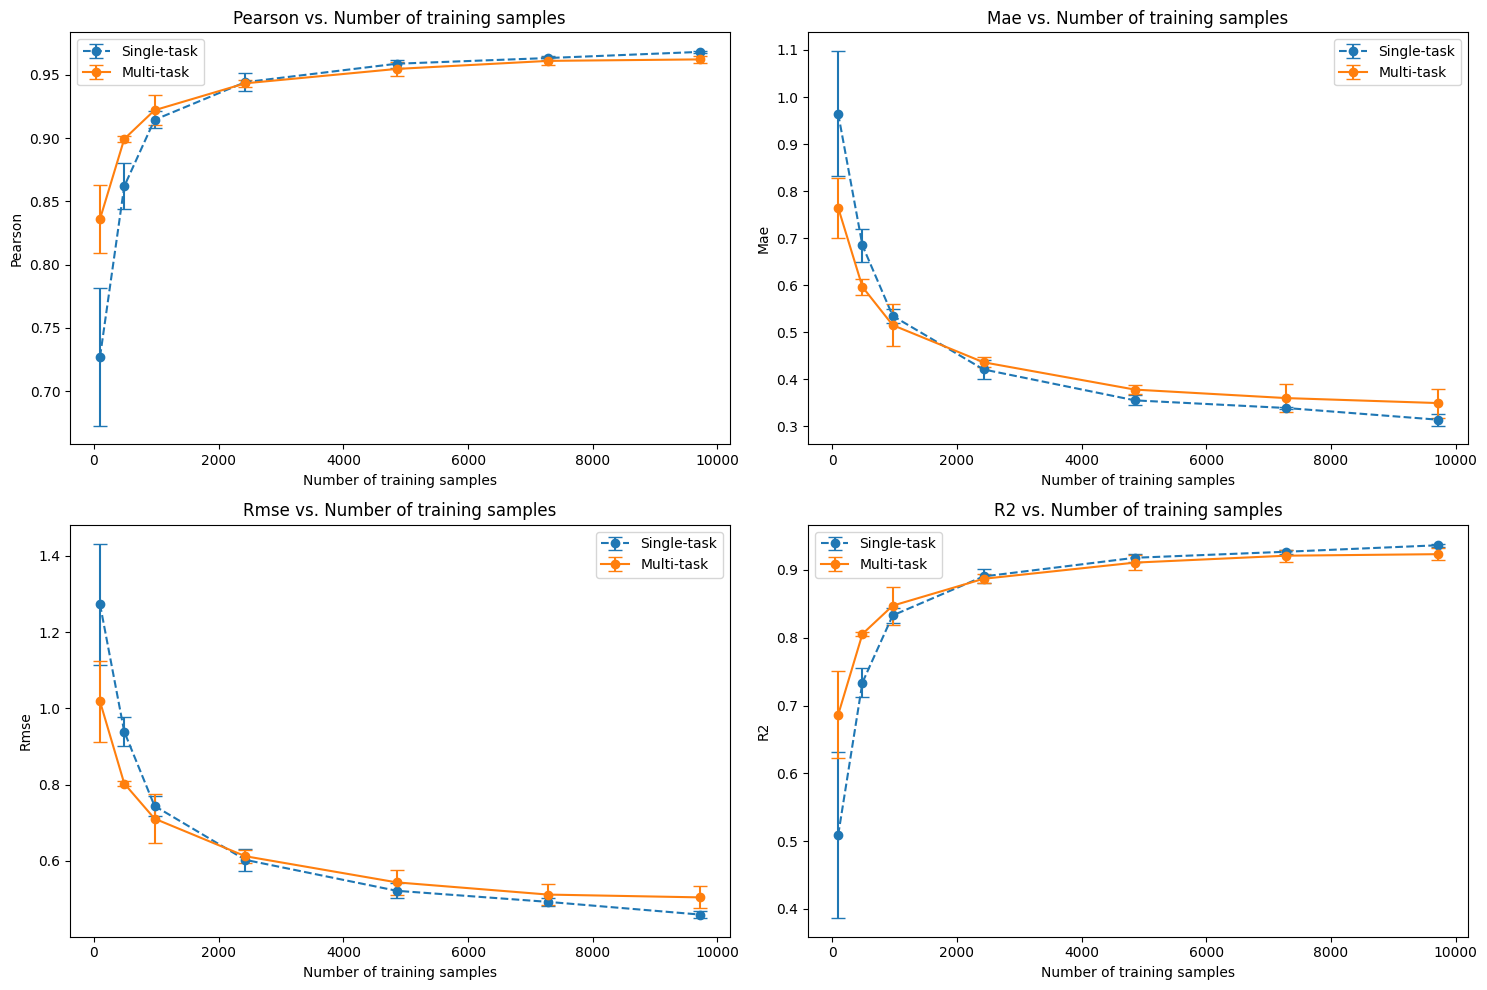

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the dataset sizes and output directory
sizes = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 1]
out_dir = 'LogP_different_sizes/'

# Function to calculate 90% confidence interval
def confidence_interval(data, confidence=0.90):
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin_of_error = sem * t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Initialize dictionary to store results
metrics = ["pearson", "mae", "rmse", "r2"]
results = {metric: {s: {"single_task": [], "multi_task": []} for s in sizes} for metric in metrics}

# Collect metrics for each dataset size and each seed
for seed in range(3):
    for s in sizes:
        # Prepare data for single-task
        single_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_STL/preds_0.csv')
        valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_single_values = valid_single["LogP"]
        pred_single_values = valid_single['pred_0']

        # Prepare data for multi-task
        multi_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_MTL/preds_0.csv')
        valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_multi_values = valid_multi["LogP"]
        pred_multi_values = valid_multi['pred_0']

        # Calculate metrics and store results
        results["pearson"][s]["single_task"].append(pearsonr(true_single_values, pred_single_values)[0])
        results["mae"][s]["single_task"].append(mean_absolute_error(true_single_values, pred_single_values))
        results["rmse"][s]["single_task"].append(mean_squared_error(true_single_values, pred_single_values, squared=False))
        results["r2"][s]["single_task"].append(r2_score(true_single_values, pred_single_values))

        results["pearson"][s]["multi_task"].append(pearsonr(true_multi_values, pred_multi_values)[0])
        results["mae"][s]["multi_task"].append(mean_absolute_error(true_multi_values, pred_multi_values))
        results["rmse"][s]["multi_task"].append(mean_squared_error(true_multi_values, pred_multi_values, squared=False))
        results["r2"][s]["multi_task"].append(r2_score(true_multi_values, pred_multi_values))

# Calculate mean and confidence intervals for each metric
aggregated_results = {metric: [] for metric in metrics}

for metric in metrics:
    for s in sizes:
        single_mean, single_lower, single_upper = confidence_interval(results[metric][s]["single_task"])
        multi_mean, multi_lower, multi_upper = confidence_interval(results[metric][s]["multi_task"])
        aggregated_results[metric].append([s, single_mean, single_lower, single_upper, multi_mean, multi_lower, multi_upper])

# Convert results to DataFrames
dfs = {metric: pd.DataFrame(aggregated_results[metric], columns=["Size", "Single-task mean", "Single-task lower CI", "Single-task upper CI",
                                                                 "Multi-task mean", "Multi-task lower CI", "Multi-task upper CI"]) for metric in metrics}

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (metric, df) in zip(axs.flatten(), dfs.items()):
    ax.errorbar(df["Size"] * len(stl_data), df["Single-task mean"],
                yerr=[df["Single-task mean"] - df["Single-task lower CI"],
                      df["Single-task upper CI"] - df["Single-task mean"]],
                label="Single-task", fmt='o', capsize=5,ls='--')
    ax.errorbar(df["Size"] * len(stl_data), df["Multi-task mean"],
                yerr=[df["Multi-task mean"] - df["Multi-task lower CI"],
                      df["Multi-task upper CI"] - df["Multi-task mean"]],
                label="Multi-task", fmt='o', ls='-', capsize=5)
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel(metric.capitalize().replace("_", " "))
    ax.legend()
    ax.set_title(f'{metric.capitalize().replace("_", " ")} vs. Number of training samples')

plt.tight_layout()
plt.show()



In [13]:
# Just plot the R2
from sklearn.metrics import r2_score

r2 = []

for s in sizes:
    # Prepare data for single-task
    single_task_df = pd.read_csv(out_dir + f'{s}_STL/preds_0.csv')
    valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_single_values = valid_single["LogP"]
    pred_single_values = valid_single['pred_0']

    # Prepare data for multi-task
    multi_task_df = pd.read_csv(out_dir + f'{s}_MTL/preds_0.csv')
    valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_multi_values = valid_multi["LogP"]
    pred_multi_values = valid_multi['pred_0']

    r2.append([s, r2_score(true_single_values, pred_single_values), r2_score(true_multi_values, pred_multi_values)])

r2 = pd.DataFrame(r2, columns=["Size", "Single-task", "Multi-task"])
r2.set_index("Size", inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(r2.index*len(stl_data), r2["Single-task"], label="Single-task", marker='o')
plt.plot(r2.index*len(stl_data), r2["Multi-task"], label="Multi-task", marker='o', ls='--')

plt.xlabel("Number of training samples")
plt.ylabel("$R^2$")
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'LogP_different_sizes/0.01_STL/preds_0.csv'

: 